In [1]:
import cv2
import os
import numpy as np
from common import CV_DATASETS_DIR
from pathlib import Path
from PIL import Image

TRAIN_IMAGES = CV_DATASETS_DIR / 'yalefaces' / 'train'
TESTS_IMAGES = CV_DATASETS_DIR / 'yalefaces' / 'test'

face_cascade = cv2.CascadeClassifier('/usr/share/opencv4/haarcascades/haarcascade_frontalface_alt.xml')
assert  not face_cascade.empty()

def get_image_label(filename: str) -> int:
    label = str()
    for ch in filename:
        if ch.isdigit():
            label += ch
    return int(label)

def get_image_data(path: Path) -> ([np.array], [int]):
    images = []
    labels = []
    for filename in os.listdir(path):
        file = Path(os.path.join(path, filename))
        if file.is_file():
            try:
                images.append(np.array(Image.open(file).convert('L'), 'uint8'))
                labels.append(get_image_label(filename))
            except OSError as e:
                print(f'Unable to read <{file}> file: {e.strerror}')
    return images, np.array(labels)

def preprocess_image_data(images: [np.array], padding: int = 5, kernel: int = 7, sigma: float = 0.0) -> [np.array]:
    output = []
    for image in images:
        faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5)
        for (x, y, w, h) in faces:
            # Crop image
            cropped_image = image[y - padding + 1 : y + h + padding, x - padding + 1 : x + w + padding]
            # Remove noise
            cv2.GaussianBlur(cropped_image, [kernel, kernel], 0, image, sigma, cv2.BORDER_DEFAULT)
            # Equalize histogram
            cv2.equalizeHist(cropped_image, cropped_image)
            # Add image
            output.append(cropped_image)
    return output

train_images, train_labels = get_image_data(TRAIN_IMAGES)
train_images = preprocess_image_data(train_images, padding=5)

In [2]:
# Train and save classifier
from common import CV_WORKAREA_DIR
classifier1 = cv2.face.LBPHFaceRecognizer.create()
classifier1.train(train_images, train_labels)
classifier1.write(str(CV_WORKAREA_DIR / 'lbph_classifier.yml'))

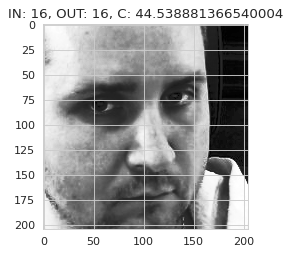

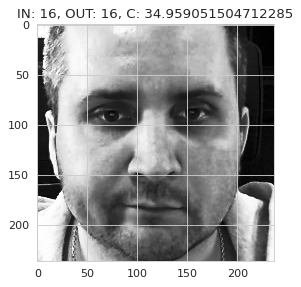

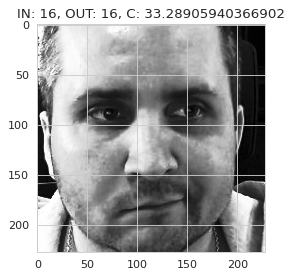

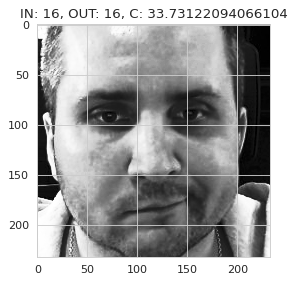

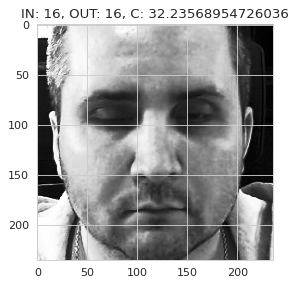

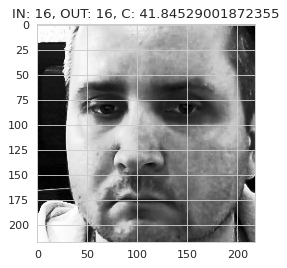

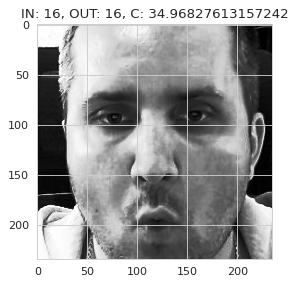

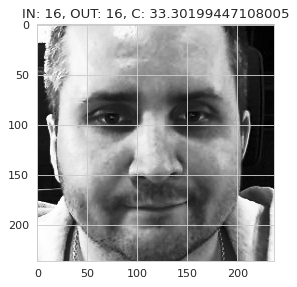

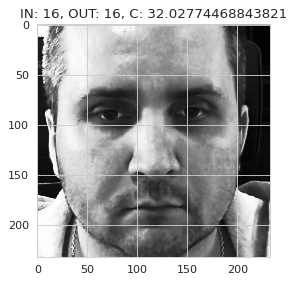

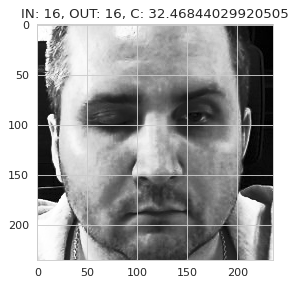

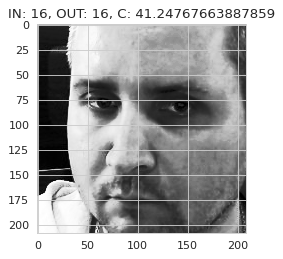

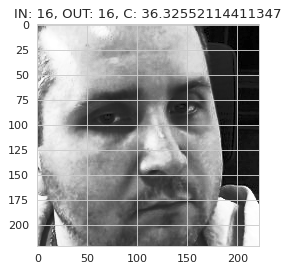

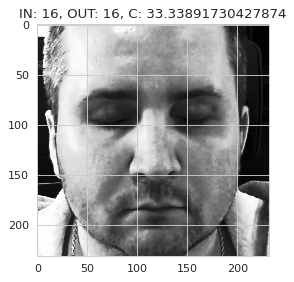

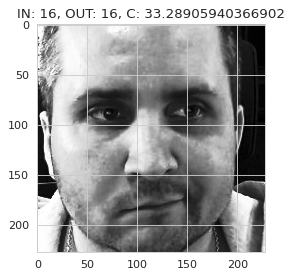

In [4]:
# Load classifier and recognize faces
classifier2 = cv2.face.LBPHFaceRecognizer.create()
classifier2.read(str(CV_WORKAREA_DIR / 'lbph_classifier.yml'))

predictions = []
expected = []
tests_images, tests_labels = get_image_data(TESTS_IMAGES)
tests_images = preprocess_image_data(tests_images)
for image, label in zip(tests_images, tests_labels):
    predict, confidence = classifier2.predict(image)
    predictions.append(predict)
    expected.append(label)

predictions = np.array(predictions)
expected = np.array(expected)


Accuracy: 77.2%


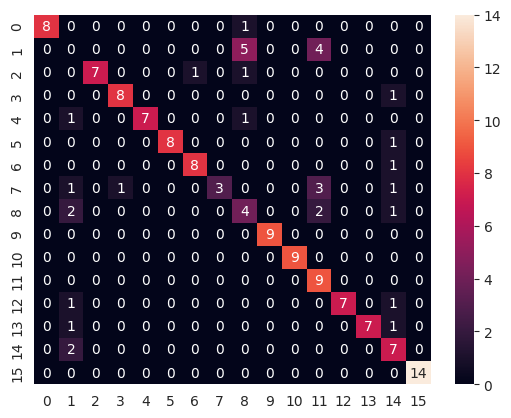

In [55]:
# Evaluate recognizing result
import seaborn
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(expected, predictions)
print(f'Accuracy: {accuracy * 100:.3}%')

cm = confusion_matrix(expected, predictions)
seaborn.heatmap(cm, annot=True);
